# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

Loading required package: nlme
This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


In [3]:
columb.head()

,index,area,home.value,income,crime,open.space,district,x,y
0,0,0.309441,80.467003,19.531,15.725980,2.850747,0,8.827218,14.369076
1,1,0.259329,44.567001,21.232,18.801754,5.296720,1,8.332658,14.031624
2,2,0.192468,26.350000,15.956,30.626781,4.534649,2,9.012265,13.819719
3,3,0.083841,33.200001,4.477,32.387760,0.394427,3,8.460801,13.716962
4,4,0.488888,23.225000,11.252,50.731510,0.405664,4,9.007982,13.296366


## Model Definition

### Setup response model

In [4]:
df = columb
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)


smooth = tb.ps("area")

loc += smooth
loc += tb.rs(x=smooth, cluster="district")

loc += tb.ri("district", noncentered=True)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


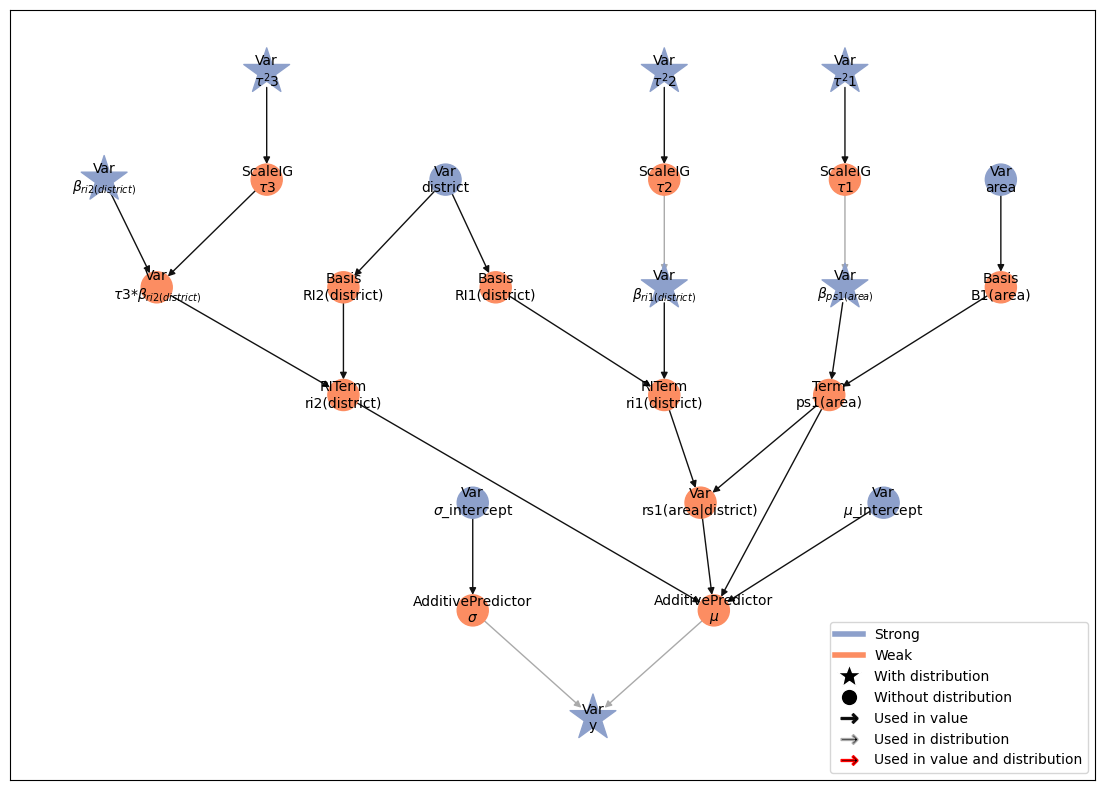

In [5]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [6]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\mu$_intercept', '$\\beta_{ri2(district)}$', '$\\tau^2$3', '$\\beta_{ri1(district)}$', '$\\tau^2$2', '$\\beta_{ps1(area)}$', '$\\tau^2$1'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:05<00:00,  2.83chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 938.95chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|█████████████████████████████████████████| 2/2 [00:00<00:00, 928.46ch

### MCMC summary

In [7]:
summary = gs.Summary(results)
summary

Parameter summary:

                              kernel       mean         sd     q_0.05  \
parameter           index                                               
$\beta_{ps1(area)}$ (0,)   kernel_06  -0.000254   0.477287  -0.737185   
                    (1,)   kernel_06  -0.009588   0.466934  -0.770108   
                    (2,)   kernel_06  -0.016041   0.471573  -0.760221   
                    (3,)   kernel_06   0.013570   0.469234  -0.692128   
                    (4,)   kernel_06  -0.004001   0.481078  -0.734348   
...                              ...        ...        ...        ...   
$\mu$_intercept     ()     kernel_01  35.045731   2.076592  31.584722   
$\sigma$_intercept  ()     kernel_00   2.626161   0.118954   2.439085   
$\tau^2$1           ()     kernel_07   0.226492   0.392980   0.005114   
$\tau^2$2           ()     kernel_05   0.031466   0.096978   0.001651   
$\tau^2$3           ()     kernel_03   2.181163  14.262347   0.001133   

                               q_0.5     q_0.95  sample_size     ess_bulk  \
parameter           index                                                   
$\beta_{ps1(area)}$ (0,)   -0.000476   0.732682         4000  2958.544615   
                    (1,)   -0.005997   0.713946         4000  3590.399183   
                    (2,)   -0.006876   0.715969         4000  3359.293677   
                    (3,)    0.003775   0.758056         4000  3470.357379   
                    (4,)   -0.004122   0.739392         4000  3373.493394   
...                              ...        ...          ...          ...   
$\mu$_intercept     ()     35.065111  38.420711         4000  3640.261304   
$\sigma$_intercept  ()      2.624405   2.824024         4000  1209.793626   
$\tau^2$1           ()      0.120395   0.778318         4000   216.799642   
$\tau^2$2           ()      0.007192   0.130620         4000    97.432490   
$\tau^2$3           ()      0.017541   6.116681         4000   436.874838   

                              ess_tail      rhat  
parameter           index                         
$\beta_{ps1(area)}$ (0,)   2474.349287  1.012442  
                    (1,)   2509.580443  1.005069  
                    (2,)   2583.615274  1.009770  
                    (3,)   2572.767348  1.006335  
                    (4,)   2215.875495  1.010115  
...                                ...       ...  
$\mu$_intercept     ()     3487.096694  1.000179  
$\sigma$_intercept  ()     2191.747004  1.003225  
$\tau^2$1           ()      362.346144  1.021547  
$\tau^2$2           ()       80.126125  1.025745  
$\tau^2$3           ()      502.658221  1.009390  

[122 rows x 10 columns]

## Plots

In [8]:
samples = results.get_posterior_samples()

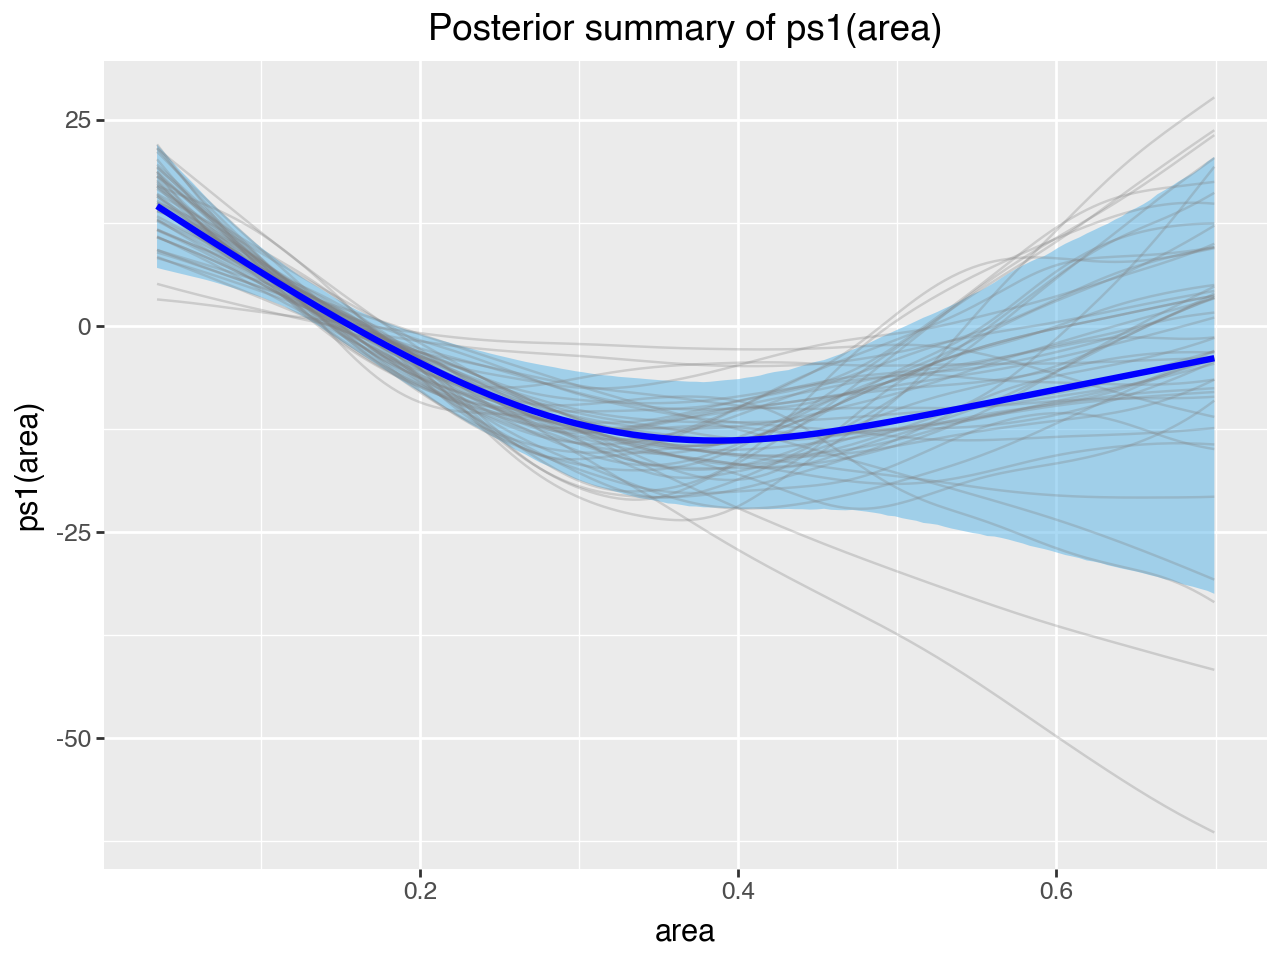

In [9]:
gam.plot_1d_smooth(term=model.vars[smooth.name], samples=samples)

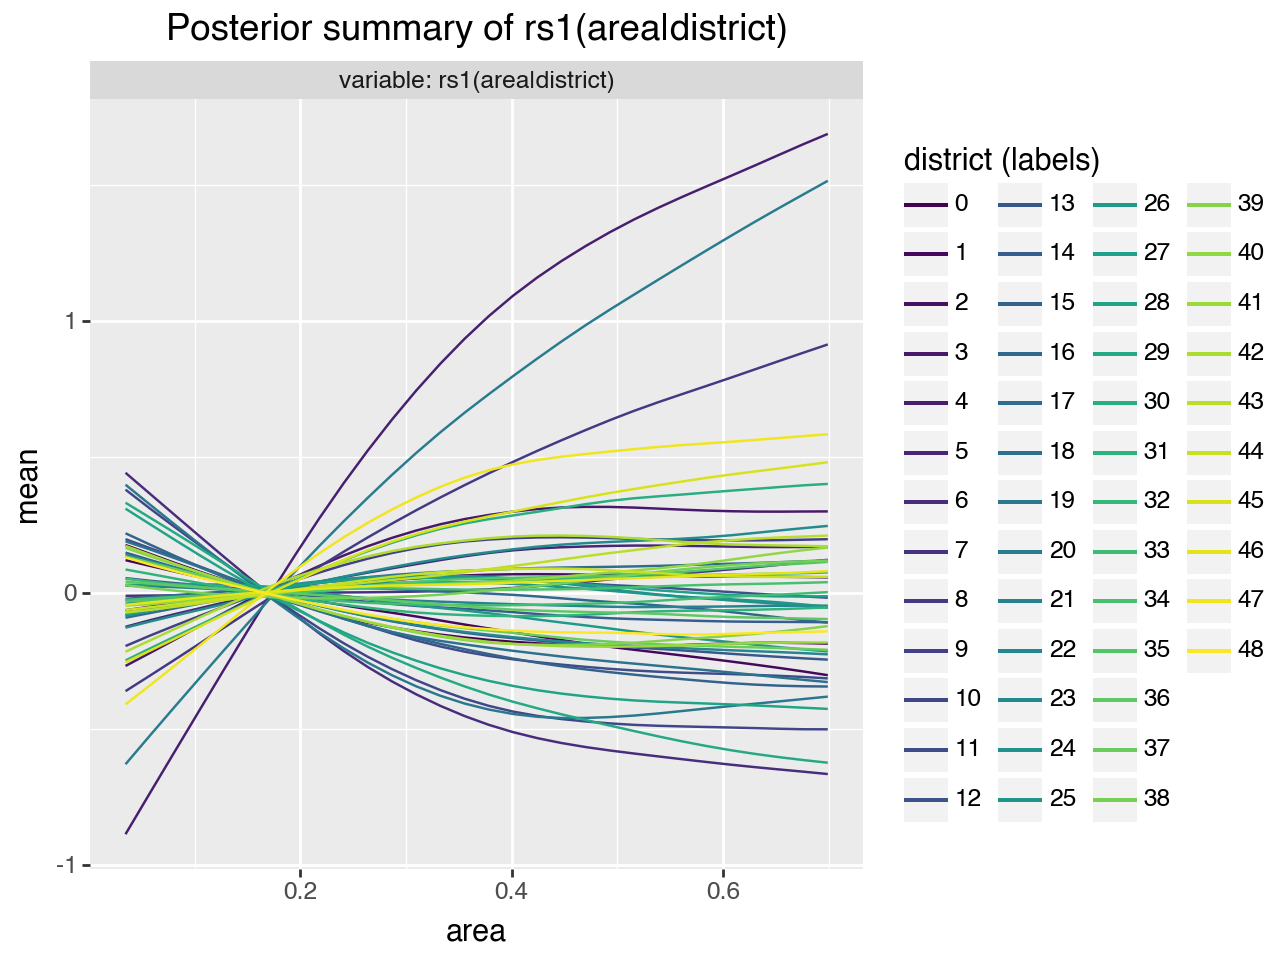

In [10]:
gam.plot_1d_smooth_clustered(
    clustered_term=model.vars["rs1(area|district)"],
    samples=samples,
    ngrid=30,
)

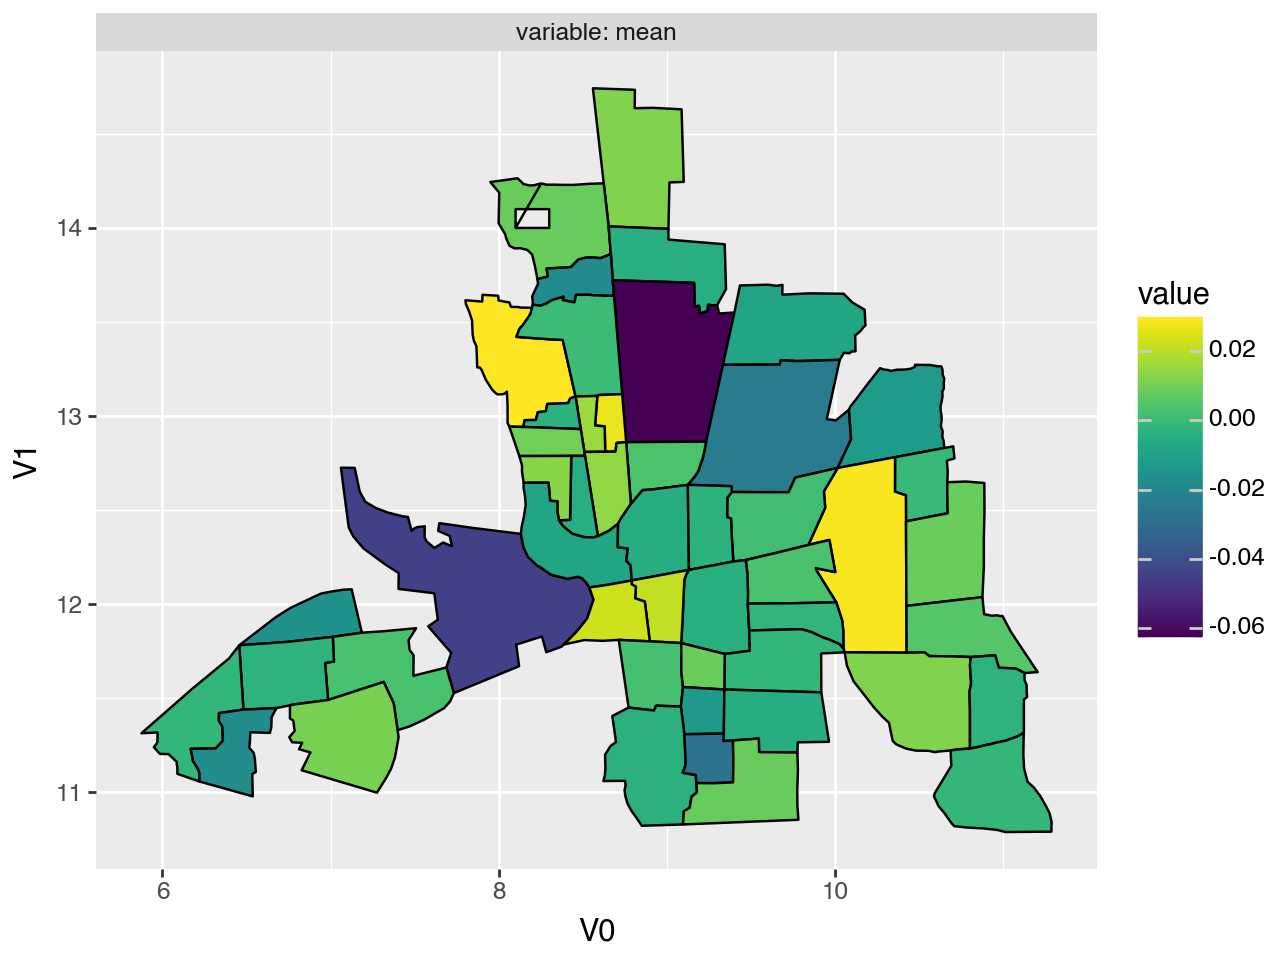

In [11]:
(
    gam.plot_regions(
        term=model.vars["ri1(district)"], samples=samples, polys=polys, color="black"
    )
)

/Users/johannesbrachem/Documents/git/liesel_gam/.venv/lib/python3.13/site-packages/plotnine/guides/guides.py:211: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


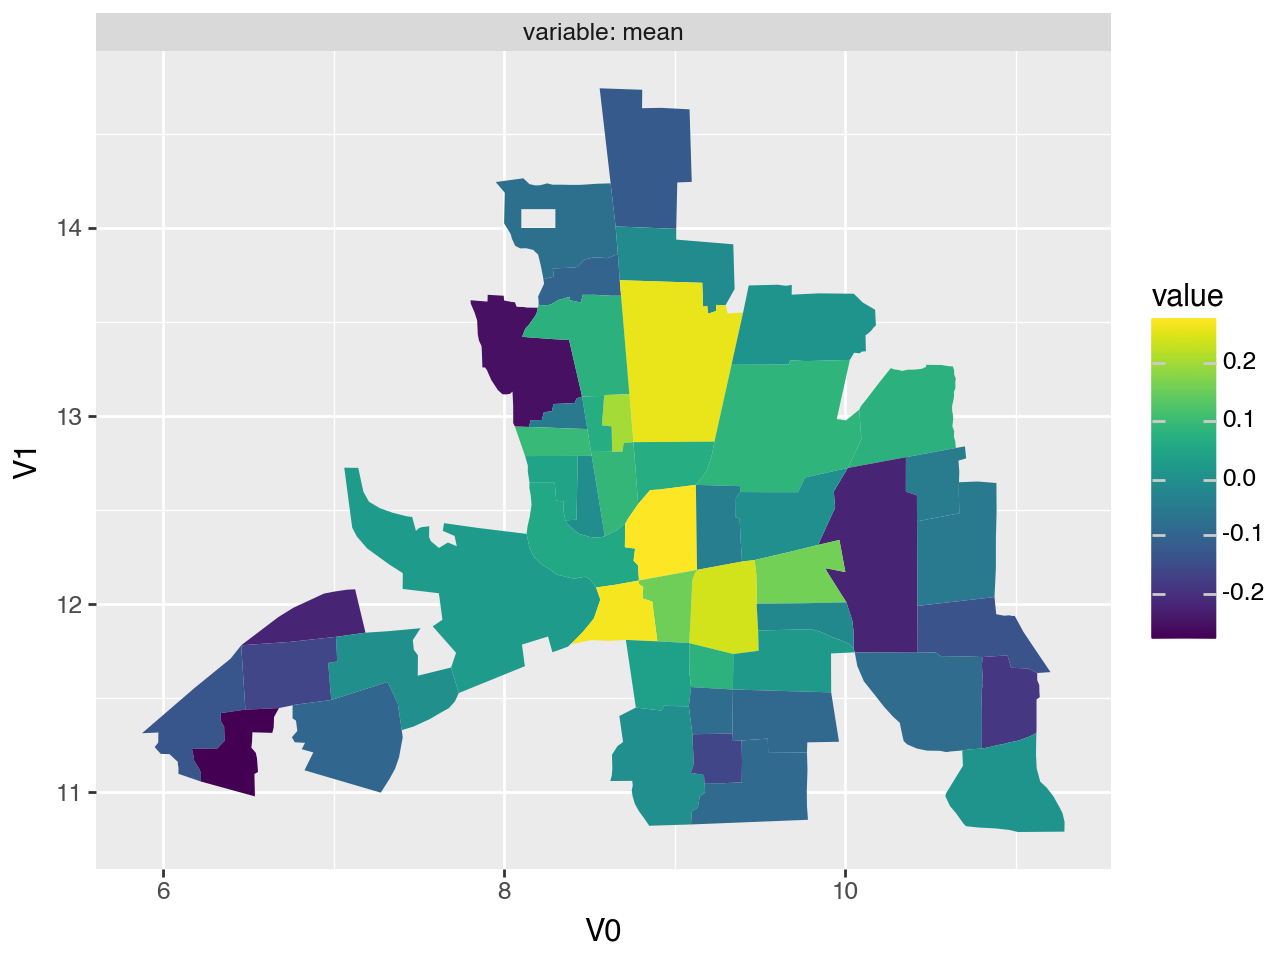

In [12]:
import plotnine as p9

gam.plot_regions(
    term=model.vars["ri2(district)"], samples=samples, polys=polys
) + p9.scale_color_cmap_d(limits=(-1.0, 1.0))